In [330]:
import IO_map
import random
import re
import generate_verilog as gv
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import re

"""
Wire can be in many groups: A wire can be on many linear paths
    - Every wire is initally in a group with it's parent and child modules
Wire can be in many loops: A wire can be on many looped paths
Groups contains {group_id : [modules in that group]}
    - Initially one group for every input and output pair 
    - Group id is initially the wire id, since each wire is in it's own group
Loops contains {loop_id : [modules in that loop]}

"""
class Fuzz_Run:
    def __init__(self, flattened_lib_path):
        random.seed(1)
        self.flattened_lib_path = flattened_lib_path
        io_map = IO_map.create_IO_map(flattened_lib_path)

        self.all_wires = io_map['bit_input'].copy()
        self.all_wires.update(io_map['bit_output']) # Single source of truth
        
        self.mod_IO = io_map['mod_IO']
        self.all_modules = io_map['mod_list']

        self.external_inputs = list(io_map['bit_input'].keys())
        self.external_outputs = list(io_map['bit_output'].keys()) # Unchanged will always output all outputs

        self.module_tree = {}
        for i in range(len(io_map['mod_list'])):
            module = io_map['mod_list'][i]
            self.module_tree[module] = {"depth" : 0, "tree":i, "children" : [], "parents":[]}

    def visualize_graph(self):
        G = nx.DiGraph()
        G.add_node("EXT_INPUT", color="green")
        G.add_node("EXT_OUTPUT", color="red")

        for mod in self.all_modules:
            G.add_node(mod, color="lightblue")

        edge_labels = defaultdict(list)

        for wire in self.all_wires.values():
            if wire.type == IO_map.Wire.Wire_Type.ITM:
                # EXT_INPUT → module
                dst_port = wire.output[0] if wire.output else None
                if dst_port and "_input_" in dst_port:
                    dst_mod = dst_port.split("_input_")[0]
                    G.add_edge("EXT_INPUT", dst_mod)
                    edge_labels[("EXT_INPUT", dst_mod)].append(f"w{wire.id}")

            elif wire.type == IO_map.Wire.Wire_Type.MTM:
                src_port = wire.input
                if "_output_" not in src_port:
                    continue
                src_mod = src_port.split("_output_")[0]
                for dst in wire.output:
                    if dst == "output":
                        G.add_edge(src_mod, "EXT_OUTPUT")
                        edge_labels[(src_mod, "EXT_OUTPUT")].append(f"w{wire.id}")
                    elif "_input_" in dst:
                        dst_mod = dst.split("_input_")[0]
                        G.add_edge(src_mod, dst_mod)
                        edge_labels[(src_mod, dst_mod)].append(f"w{wire.id}")

        pos = nx.spring_layout(G, seed=42)
        node_colors = [G.nodes[n].get("color", "white") for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=8, edge_color="gray")
        formatted_labels = {k: ", ".join(v) for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, font_size=6)

        plt.title("Module Graph (ITM / MTM Wiring Only)")
        plt.show()

    def visualize_graph_no_ext_out(self):
        G = nx.DiGraph()
        G.add_node("EXT_INPUT", color="green")

        for mod in self.all_modules:
            G.add_node(mod, color="lightblue")

        # Track directional edges separately
        directional_edges = defaultdict(list)

        for wire in self.all_wires.values():
            if wire.type == IO_map.Wire.Wire_Type.ITM:
                dst_port = wire.output[0] if wire.output else None
                if dst_port and "_input_" in dst_port:
                    dst_mod = dst_port.split("_input_")[0]
                    G.add_edge("EXT_INPUT", dst_mod)
                    directional_edges[("EXT_INPUT", dst_mod)].append(f"w{wire.id}")

            elif wire.type == IO_map.Wire.Wire_Type.MTM:
                src_port = wire.input
                if "_output_" not in src_port:
                    continue
                src_mod = src_port.split("_output_")[0]
                for dst in wire.output:
                    if dst == "output":
                        continue
                    if "_input_" in dst:
                        dst_mod = dst.split("_input_")[0]
                        G.add_edge(src_mod, dst_mod)
                        directional_edges[(src_mod, dst_mod)].append(f"w{wire.id}")

        # Draw nodes and graph layout
        pos = nx.spring_layout(G, seed=42)
        node_colors = [G.nodes[n].get("color", "white") for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=8, edge_color="gray")

        # For every unique directed edge, render only its labels
        final_labels = {
            (src, dst): ", ".join(wire_ids)
            for (src, dst), wire_ids in directional_edges.items()
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=final_labels, font_size=6)

        plt.title("Module Graph with Full Directional Wire Labels")
        plt.show()



    def generate_top_module(self):
        """
        Generate a top-level Verilog module string based on self.all_wires, self.mod_IO, and I/O structure.
        Avoids any parsing of port names; uses structured data only.
        """
        ext_inputs = self.external_inputs
        ext_outputs = self.external_outputs
        wire_map = self.all_wires
        mod_IO = self.mod_IO

        ext_in_pos = {wid: i for i, wid in enumerate(ext_inputs)}
        ext_out_pos = {wid: j for j, wid in enumerate(ext_outputs)}

        # Determine per-module input/output wire order
        mod_in_order = {mod: sorted(io['inputs']) for mod, io in mod_IO.items()}
        mod_out_order = {mod: sorted(io['outputs']) for mod, io in mod_IO.items()}

        mod_in_width  = {mod: len(bits) for mod, bits in mod_in_order.items()}
        mod_out_width = {mod: len(bits) for mod, bits in mod_out_order.items()}

        lines = []
        lines.append("// Auto-generated top module")
        lines.append("module top (")
        if ext_inputs:
            lines.append(f"    input  wire [{len(ext_inputs)-1}:0] in_flat,")
        else:
            lines.append("    // no external inputs")
        if ext_outputs:
            lines.append(f"    output wire [{len(ext_outputs)-1}:0] out_flat")
        else:
            lines.append("    // no external outputs")
        lines.append(");\n")

        # `include directives
        for mod in sorted(self.all_modules):
            lines.append(f"`include \"{mod}.sv\"")
        lines.append("")

        # Declare per-module buses
        lines.append("  // Per-module I/O buses")
        for mod in sorted(self.all_modules):
            inW  = mod_in_width[mod]
            outW = mod_out_width[mod]
            if inW:
                lines.append(f"  wire [{inW-1}:0] {mod}_in_flat;")
            else:
                lines.append(f"  // {mod} has no inputs")
            if outW:
                lines.append(f"  wire [{outW-1}:0] {mod}_out_flat;")
            else:
                lines.append(f"  // {mod} has no outputs")
        lines.append("")

        # Drive module inputs from in_flat
        if ext_inputs:
            lines.append("  // Drive module inputs from in_flat")
            for wire_id in ext_inputs:
                wire = wire_map[wire_id]
                # print(wire, wire.type)
                assert wire.type == IO_map.Wire.Wire_Type.ITM
                dst = wire.output[0]  # e.g., adder_wrapper_input_0
                mod = self._mod_from_port(dst)
                bitidx = mod_in_order[mod].index(wire_id)
                lines.append(f"  assign {mod}_in_flat[{bitidx}] = in_flat[{ext_in_pos[wire_id]}];")
            lines.append("")

        # Internal connections
        lines.append("  // Internal connections")
        for wire in wire_map.values():
            if wire.type != IO_map.Wire.Wire_Type.MTO:
                continue
            src_mod = wire.input
            src_bit = mod_out_order[src_mod].index(wire.id)

            for dst in wire.output:
                if dst == "output":
                    continue  # skip output binding here
                dst_mod = self._mod_from_port(dst)
                print(src_mod, dst_mod)
                dst_bit = mod_in_order[dst_mod].index(
                    next(wid for wid in mod_IO[dst_mod]['inputs'] if dst in wire_map[wid].output)
                )
                lines.append(f"  assign {dst_mod}_in_flat[{dst_bit}] = {src_mod}_out_flat[{src_bit}];")
        lines.append("")

        # Drive out_flat from module outputs
        if ext_outputs:
            lines.append("  // Drive out_flat from module outputs")
            for wire_id in ext_outputs:
                wire = wire_map[wire_id]
                assert wire.type == IO_map.Wire.Wire_Type.MTO
                mod = wire.input
                bitidx = mod_out_order[mod].index(wire_id)
                lines.append(f"  assign out_flat[{ext_out_pos[wire_id]}] = {mod}_out_flat[{bitidx}];")
            lines.append("")

        # Instantiate modules
        lines.append("  // Instantiate modules")
        for mod in sorted(self.all_modules):
            inW  = mod_in_width[mod]
            outW = mod_out_width[mod]
            if not (inW or outW):
                lines.append(f"  // skip {mod}: no I/O")
                continue
            lines.append(f"  {mod} u_{mod} (")
            ports = []
            if inW:  ports.append(f"    .in_flat  ({mod}_in_flat)")
            if outW: ports.append(f"    .out_flat ({mod}_out_flat)")
            for idx, p in enumerate(ports):
                suffix = "," if idx < len(ports)-1 else ""
                lines.append(p + suffix)
            lines.append("  );")
        lines.append("\nendmodule")

        return "\n".join(lines)

    def _mod_from_port(self, port_str):
        """Helper function to extract module name from a port string like 'adder_wrapper_input_3'."""
        if "_input_" in port_str:
            return port_str.split("_input_")[0]
        elif "_output_" in port_str:
            return port_str.split("_output_")[0]
        raise ValueError(f"Unrecognized port name format: {port_str}")

    def linear_rewire(self):
        """
        Rewire one external output (MTM) to an internal input (ITM).
        Ensures the old driver is removed and tree structure updated.
        """
        potential_outputs = self.external_outputs.copy()
        random.shuffle(potential_outputs)

        for output_wire_id in potential_outputs:
            output_wire = self.all_wires[output_wire_id]
            assert(output_wire.type == IO_map.Wire.Wire_Type.MTM)

            output_port = output_wire.input  # e.g., "adder_wrapper_output_0"
            assert( "_output_" in output_port)

            output_mod = output_port.split("_output_")[0]
            output_tree = self.module_tree[output_mod]["tree"]
            output_depth = self.module_tree[output_mod]["depth"]

            candidate_modules = self.all_modules.copy()
            random.shuffle(candidate_modules)

            for target_mod in candidate_modules:
                if target_mod == output_mod:
                    continue

                target_tree = self.module_tree[target_mod]["tree"]
                target_depth = self.module_tree[target_mod]["depth"]
                if target_tree == output_tree and target_depth < output_depth:
                    continue  # would create cycle

                target_inputs = self.mod_IO[target_mod]['inputs'].copy()
                # target_inputs.remove("output")
                target_inputs = list(target_inputs)

                target_wire_id = random.choice(target_inputs)
                target_wire = self.all_wires[target_wire_id]

                valid_ports = list(filter(("output".__ne__), target_wire.output))
                random.shuffle(valid_ports)
                target_port = None

                for port in valid_ports:
                    target_mod_from_port = port.split("_input_")[0]
                    if target_mod_from_port == output_mod:
                        continue
                    else:
                        target_port = port

                if target_port == None:
                    continue

                # Add new wire connection 
                output_wire.output.append(target_port)

                # Adjust the module's input list
                self.mod_IO[target_mod]['inputs'].remove(target_wire_id)
                self.mod_IO[target_mod]['inputs'].add(output_wire_id)

                # Disconnect the wire's output
                self.all_wires[target_wire_id].output.remove(target_port)

                # If this wire recieves its data from ext input, then we need to remove it
                # if its not outputting to any ports. Otherwise its receiving it's data from
                # a module, and will always be connected to the ext output.
                if target_wire.type == IO_map.Wire.Wire_Type.ITM and len(target_wire.output) == 0:
                    self.all_wires.pop(target_wire.id)
                    self.external_inputs.remove(target_wire.id)

                # Modify tree
                if (target_tree != output_tree):
                    self.module_tree[target_mod]['tree'] = self.module_tree[output_mod]['tree'] # Merge trees

                if(target_depth == output_depth):
                    self.module_tree[target_mod]['depth'] = self.module_tree[output_mod]['depth'] + 1 # Adjust depth

                print(f"[Rewire] {output_mod} → {target_mod} via {target_port}")
                return

        print("[Rewire] No valid rewiring opportunity found.")


In [350]:
test_fuzz = Fuzz_Run("/module-fuzz/test_library/flattened_IO")

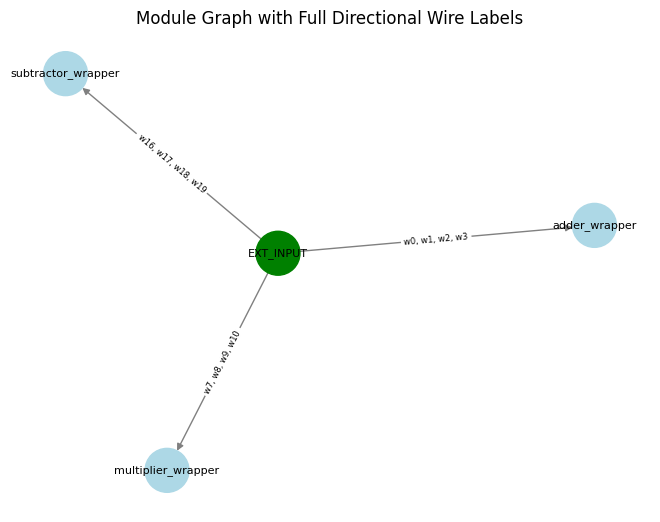

In [351]:
test_fuzz.visualize_graph_no_ext_out()

[Rewire] multiplier_wrapper → adder_wrapper via adder_wrapper_input_0


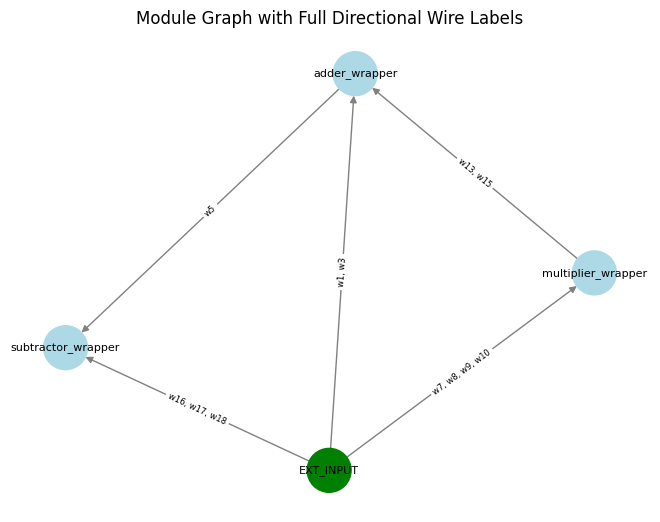

{1: Wire(id=1, in='input', out=['adder_wrapper_input_1']),
 3: Wire(id=3, in='input', out=['adder_wrapper_input_3']),
 7: Wire(id=7, in='input', out=['multiplier_wrapper_input_0']),
 8: Wire(id=8, in='input', out=['multiplier_wrapper_input_1']),
 9: Wire(id=9, in='input', out=['multiplier_wrapper_input_2']),
 10: Wire(id=10, in='input', out=['multiplier_wrapper_input_3']),
 16: Wire(id=16, in='input', out=['subtractor_wrapper_input_0']),
 17: Wire(id=17, in='input', out=['subtractor_wrapper_input_1']),
 18: Wire(id=18, in='input', out=['subtractor_wrapper_input_2']),
 4: Wire(id=4, in='adder_wrapper_output_0', out=['output']),
 5: Wire(id=5, in='adder_wrapper_output_1', out=['output', 'subtractor_wrapper_input_3']),
 6: Wire(id=6, in='adder_wrapper_output_2', out=['output']),
 11: Wire(id=11, in='multiplier_wrapper_output_0', out=['output']),
 12: Wire(id=12, in='multiplier_wrapper_output_1', out=['output']),
 13: Wire(id=13, in='multiplier_wrapper_output_2', out=['output', 'adder_wrap

In [358]:
test_fuzz.linear_rewire()
test_fuzz.visualize_graph_no_ext_out()
test_fuzz.all_wires

In [347]:
test_fuzz.module_tree

{'adder_wrapper': {'depth': 1, 'tree': 1, 'children': [], 'parents': []},
 'multiplier_wrapper': {'depth': 0, 'tree': 1, 'children': [], 'parents': []},
 'subtractor_wrapper': {'depth': 2, 'tree': 1, 'children': [], 'parents': []}}

In [158]:
verilog = test_fuzz.generate_top_module()

multiplier_wrapper adder_wrapper
multiplier_wrapper adder_wrapper
multiplier_wrapper adder_wrapper
multiplier_wrapper adder_wrapper


StopIteration: 

In [152]:
print(verilog)

// Auto-generated top module
module top (
    input  wire [4:0] in_flat,
    output wire [7:0] out_flat
);

`include "adder_wrapper.sv"
`include "multiplier_wrapper.sv"

  // Per-module I/O buses
  wire [3:0] adder_wrapper_in_flat;
  wire [2:0] adder_wrapper_out_flat;
  wire [3:0] multiplier_wrapper_in_flat;
  wire [4:0] multiplier_wrapper_out_flat;

  // Drive module inputs from in_flat
  assign adder_wrapper_in_flat[0] = in_flat[0];
  assign multiplier_wrapper_in_flat[0] = in_flat[1];
  assign multiplier_wrapper_in_flat[1] = in_flat[2];
  assign multiplier_wrapper_in_flat[2] = in_flat[3];
  assign multiplier_wrapper_in_flat[3] = in_flat[4];

  // Internal connections
  assign adder_wrapper_in_flat[1] = multiplier_wrapper_out_flat[0];
  assign adder_wrapper_in_flat[2] = multiplier_wrapper_out_flat[3];
  assign adder_wrapper_in_flat[3] = multiplier_wrapper_out_flat[4];

  // Drive out_flat from module outputs
  assign out_flat[0] = adder_wrapper_out_flat[0];
  assign out_flat[1] = adde

In [ ]:
def linear_rewire(self):
        """
        Rule: 
        1. The output of a wire cannot connect to it's predecessor in the same tree. 
        2. Can pick from one of its successors, or another tree.
        3. Cant choose it's own module
        """
        # We use external_outputs because all module outputs will be a external output
        potential_outputs = self.external_outputs.copy()
        random.shuffle(potential_outputs)

        for output_wire_id in potential_outputs:
            output_wire = self.all_wires[output_wire_id]
            output_mod = output_wire.input #The module that the wire is attatched to
            output_tree = self.module_tree[output_mod]["tree"]
            output_depth = self.module_tree[output_mod]["depth"]

            # Pick a module that is not from the tree, or at a higher depth than current. Sample without replacement.
            potential_inputs = self.all_modules.copy()
            random.shuffle(potential_inputs)
            chosen_module = None
            chosen_module_tree = None
            chosen_module_depth = None

            for input_mod in potential_inputs:
                input_tree = self.module_tree[input_mod]["tree"]
                input_depth = self.module_tree[input_mod]["depth"]
                if input_mod != output_mod and (input_tree != output_tree or input_depth >= output_depth):
                    chosen_module = input_mod
                    chosen_module_tree = input_tree
                    chosen_module_depth = input_depth
                    break

            if chosen_module == None:
                print("No available module to form linear connection")
                continue
            
            else:
                # Pick a random input to chosen_module
                chosen_wire_id = random.sample(list(self.mod_IO[chosen_module]['inputs']), 1)[0]
                chosen_wire = self.all_wires[chosen_wire_id]
                chosen_output_port = random.sample(chosen_wire.output, 1)[0]

                # Add new wire connection 
                output_wire.output.append(chosen_output_port)

                # Adjust the module's input list
                self.mod_IO[chosen_module]['inputs'].remove(chosen_wire_id)
                self.mod_IO[chosen_module]['inputs'].add(output_wire_id)

                # Disconnect the wire's output
                chosen_wire.output.remove(chosen_output_port)

                # If this wire recieves its data from ext input, then we need to remove it
                # if its not outputting to any ports. Otherwise its receiving it's data from
                # a module, and will always be connected to the ext output.
                if chosen_wire.type == IO_map.Wire.Wire_Type.ITM and len(chosen_wire.output) == 0:
                    self.all_wires.pop(chosen_wire.id)
                    self.external_inputs.remove(chosen_wire.id)

                # Modify tree
                if (chosen_module_tree != output_tree):
                    self.module_tree[chosen_module]['tree'] = self.module_tree[output_mod]['tree'] # Merge trees

                if(chosen_module_depth == output_depth):
                    self.module_tree[chosen_module]['depth'] = self.module_tree[output_mod]['depth'] + 1 # Adjust depth
                
                print("Found linear rewiring combination and successfully rewired")
                return